# Using Machine Learning for Structural Identification
This notebook provides a demonstration of how a simple set of descriptors computed by freud can be coupled with machine learning for structural identification. The set of descriptors used here are not enough to identify complex crystal structures, but this notebook provides an introduction. For a more powerful set of descriptors, see the paper [Machine learning for crystal identification and discovery (Spellings 2018)](https://aiche.onlinelibrary.wiley.com/doi/full/10.1002/aic.16157) and the library [pythia](https://github.com/glotzerlab/pythia), both of which use freud for their computations.

In [1]:
import freud
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
import pandas as pd
import util

We generate sample body-centered cubic, face-centered cubic, and simple cubic structures. Each structure has at least 4000 particles.

In [2]:
N = 4000
noise = 0.1
structures = {}
n = round((N/2)**(1/3))
structures['bcc'] = util.make_bcc(nx=n, ny=n, nz=n, noise=noise)
n = round((N/4)**(1/3))
structures['fcc'] = util.make_fcc(nx=n, ny=n, nz=n, noise=noise)
n = round((N/1)**(1/3))
structures['sc'] = util.make_sc(nx=n, ny=n, nz=n, noise=noise)
for name, (box, positions) in structures.items():
    print(name, 'has', len(positions), 'particles.')

bcc has 4394 particles.
fcc has 4000 particles.
sc has 4096 particles.


Next, we compute the Steinhardt order parameters $Q_l$ for $l \in \{4, 6, 8, 10, 12\}$.

We use the Voronoi neighbor list, removing neighbors whose Voronoi facets are small.

In [3]:
def get_features(box, positions, structure):
    voro = freud.voronoi.Voronoi(box, buff=max(box.L)/2)
    voro.computeNeighbors(positions)
    nlist = voro.nlist
    nlist.filter(nlist.weights > 0.1)
    features = {}
    for l in [4, 6, 8, 10, 12]:
        ql = freud.order.LocalQl(box, rmax=max(box.L)/2, l=l)
        ql.compute(positions, nlist)
        Ql = ql.Ql.copy()
        features['q{}'.format(l)] = Ql
        
    return features

In [4]:
structure_features = {}
for name, (box, positions) in structures.items():
    structure_features[name] = get_features(box, positions, name)

Here, we plot a histogram of the $Q_4$ and $Q_6$ values for each structure.

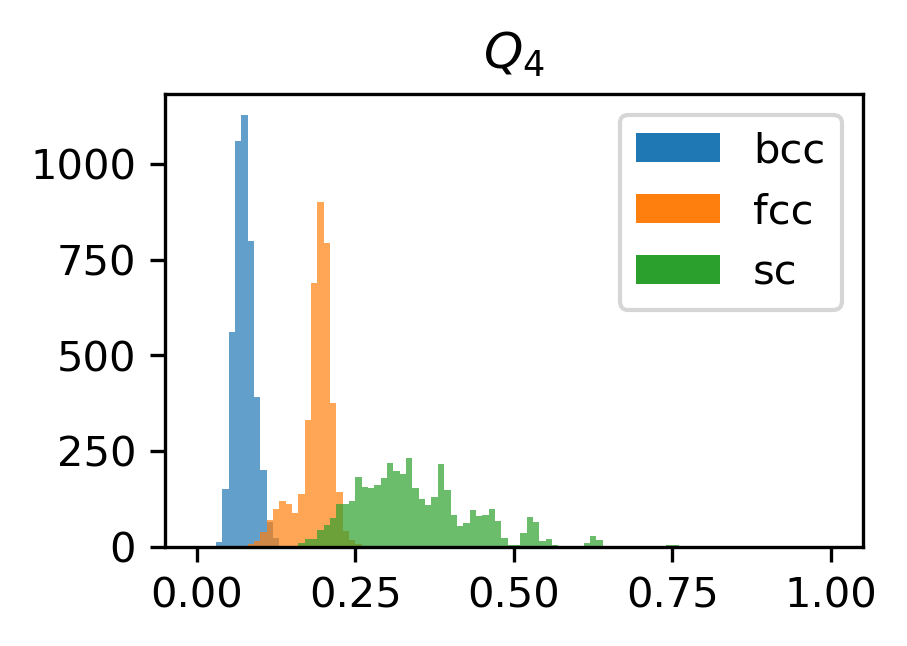

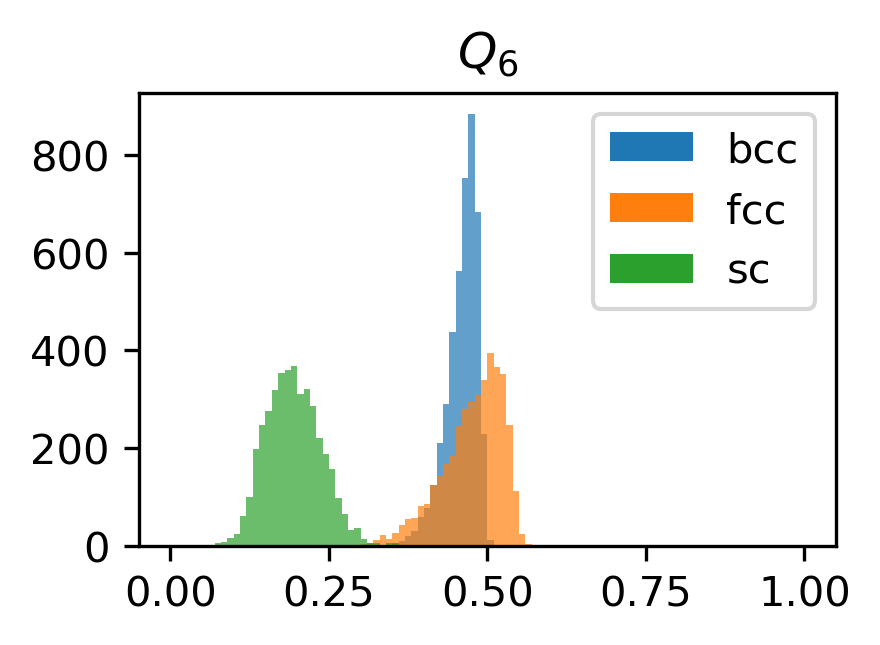

In [5]:
for l in [4, 6]:
    plt.figure(figsize=(3, 2), dpi=300)
    for name in structures.keys():
        plt.hist(structure_features[name]['q{}'.format(l)], range=(0, 1), bins=100, label=name, alpha=0.7)
    plt.title(r'$Q_{{{l}}}$'.format(l=l))
    plt.legend()
    for lh in plt.legend().legendHandles:
        lh.set_alpha(1)
    plt.show()

Next, we will train a Support Vector Machine to predict particles' structures based on these Steinhardt $Q_l$ descriptors. We build `pandas` data frames to hold the structure features, encoding the structure as an integer. We use `train_test_split` to train on part of the data and test the model on a separate part of the data.

In [6]:
structure_dfs = {}
for i, structure in enumerate(structure_features):
    df = pd.DataFrame.from_dict(structure_features[structure])
    df['class'] = i
    structure_dfs[structure] = df

In [7]:
df = pd.concat(structure_dfs.values()).reset_index(drop=True)

In [8]:
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [9]:
X = df.drop('class', axis=1).values
X = normalize(X)
y = df['class'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

svm = SVC()
svm.fit(X_train, y_train)
print('Score:', svm.score(X_test, y_test))

Score: 0.9830179524502669


Finally, we use the Uniform Manifold Approximation and Projection method ([McInnes 2018](https://arxiv.org/abs/1802.03426), [GitHub repo](https://github.com/lmcinnes/umap)) to project the high-dimensional descriptors into a two-dimensional plot. Notice that some bcc particles overlap with fcc particles. This can be expected from the noise that was added to the structures. The particles that were incorrectly classified by the SVM above are probably located in this overlapping region.

In [10]:
from umap import UMAP
umap = UMAP(random_state=42)

X_reduced = umap.fit_transform(X)

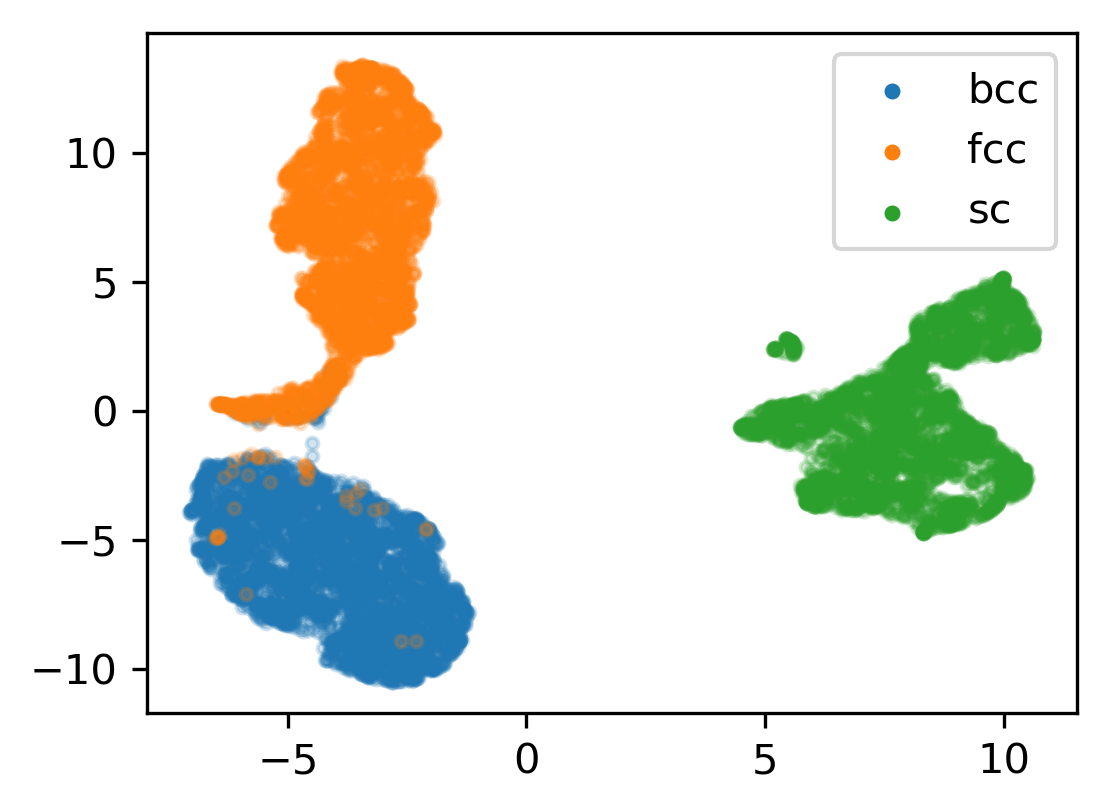

In [11]:
plt.figure(figsize=(4, 3), dpi=300)
for i in range(max(y) + 1):
    indices = np.where(y == i)[0]
    plt.scatter(X_reduced[indices, 0], X_reduced[indices, 1],
                color=matplotlib.cm.tab10(i), s=8, alpha=0.2,
                label=list(structure_features.keys())[i])
plt.legend()
for lh in plt.legend().legendHandles:
    lh.set_alpha(1)
plt.show()